In [149]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data as data
from torch.utils.data import DataLoader,TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

from utils.assimilate import run_assimilation
from models import cVAE, cLSTM

### Load/Process Data:

In [27]:
background_path = 'data/Ferguson_fire_background.npy'
background_data = np.array(np.load(open(background_path,'rb')))
background_dataset = TensorDataset(torch.Tensor(background_data))

obs_path = 'data/Ferguson_fire_obs.npy'
obs_data = np.array(np.load(open(obs_path,'rb')))
obs_dataset = TensorDataset(torch.Tensor(obs_data))

### Load Models:

In [31]:
device = 'cpu'
cvae = cVAE.VAE_Conv(device).to(device)

if not os.path.exists('models/cvae.pt'):
    print('No trained model availabe')  # do something else here
else:
    cvae.load_state_dict(torch.load('models/cvae.pt'))

cvae.eval();

In [ ]:
# load LSTM model here

### Generate Model Predictions:

In [142]:
def predict(model, background_dataset, timesteps):
    preds = []
    for i in range(len(background_dataset)):
        pred,_ = model(background_dataset[i][0].unsqueeze(0)) 
        for j in range(timestep_gap):
            if j == 0:
                pred,_ = model(background_dataset[i][0].unsqueeze(0)) 
            else:
                pred, _ = model(pred)           
        preds.append(pred.detach().numpy())
    preds = np.array(preds).squeeze() 

In [144]:
cvae_preds = predict(cvae, background_dataset, 10)

In [ ]:
# generate forecasts with LSTM here

### Compress predictions and observed data:

In [125]:
pca = PCA(n_components = 5)

obs_data_1D = np.reshape(obs_data,(obs_data.shape[0],obs_data.shape[1]*obs_data.shape[2]))
obs_data_compr = pca.fit_transform(obs_data_1D)

cvae_preds_1D = np.reshape(preds,(preds.shape[0],preds.shape[1]*preds.shape[2]))
cvae_preds_compr = pca.transform(preds_1D)

In [146]:
# compress lstm preds here

### Perform data assimilation (DA):

In [137]:
cvae_assimilated_preds = run_assimilation(cvae_preds_compr, obs_compr)
cvae_assimilated_preds = np.array(pca.inverse_transform(cvae_assimilated_preds))

In [ ]:
# perform assimilation with lstm preds here

### MSE, before vs after DA:

In [138]:
vae_before = mean_squared_error(obs_data_1D, preds_1D)
vae_after = mean_squared_error(obs_data_1D, assimilated_preds)

print(f'CVAE MSE (in physical space) before DA: {vae_before}')
print(f'CVAE MSE (in physical space) after DA: {vae_after}')

CVAE MSE (in physical space) before DA: 0.0778745543455055
CVAE MSE (in physical space) after DA: 0.008159369100889999


In [ ]:
# display mse between actual, predictions, and assimilated predictions for LSTM here

### Plot results (actual vs forecasted vs assimilated forecasted):

### Objective 1 Model (ConvVAE):

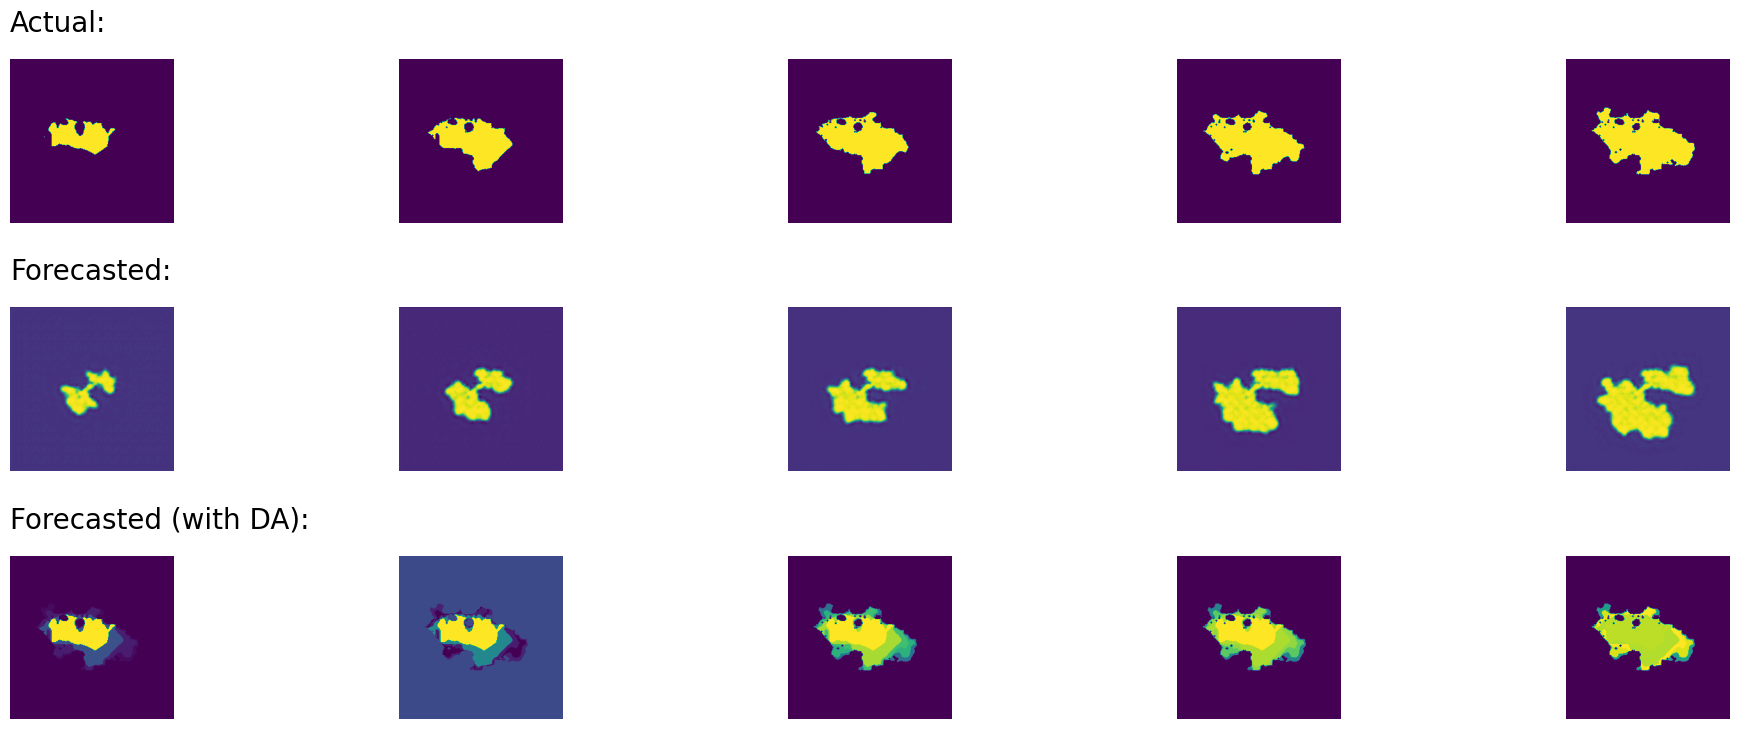

In [139]:
fig, ax = plt.subplots(3, 5, figsize=[20, 8])
fig.tight_layout(pad=4)
assimilated_preds = np.reshape(assimilated_preds, (assimilated_preds.shape[0], obs_data.shape[1],obs_data.shape[2]))
for n in range(len(background_data)):
    ax[0, n].imshow(obs_data[n])
    ax[0, n].axis('off')
    ax[1, n].imshow(preds[n])
    ax[1, n].axis('off')
    ax[2, n].imshow(assimilated_preds[n])
    ax[2, n].axis('off')    
    if n==0:
        ax[0,n].set_title('Actual:', fontsize=20, pad=20, loc='left')
        ax[1,n].set_title('Forecasted:', fontsize=20, pad=20, loc='left')
        ax[2,n].set_title('Forecasted (with DA):', fontsize=20, pad=20, loc='left')

### Objective 2 Model (ConvVAE):

In [ ]:
# visualise actual, predictions, and assimilated predictions for LSTM here